In [1]:
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms.matrix_factorization import SVDpp
from surprise.model_selection.search import GridSearchCV, RandomizedSearchCV
from surprise.model_selection.split import train_test_split
from train_valid_test_loader import load_train_valid_test_datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


In [3]:
train_tuple, valid_tuple, test_tuple, n_users, n_items = \
    load_train_valid_test_datasets()
DATA_PATH = 'data_movie_lens_100k/'
reader = Reader(
    line_format='user item rating', sep=',',
    rating_scale=(1, 5), skip_lines=1)

[    0     1     2 ... 89989 89990 89991]


In [23]:
df_training = pd.read_csv(DATA_PATH + 'ratings_all_development_set.csv')
total_dataset = Dataset.load_from_df(df_training, reader=reader)
training = total_dataset.build_full_trainset()
training_split, validation_split = train_test_split(total_dataset, random_state=124323)

In [5]:
parameter_grid = dict()
parameter_grid['random_state'] = {123453}
parameter_grid['n_epochs'] = {20, 60, 100, 150, 200, 250, 300, 350, 400}
parameter_grid['n_factors'] = {2, 10, 25, 50}
parameter_grid['lr_all'] = np.logspace(-4, 4, 9)
parameter_grid['reg_all'] = np.logspace(-4, 4, 9)
grid_searcher = RandomizedSearchCV(
    SVDpp,
    parameter_grid,
    n_iter=25,
    measures=['mae'],
    #cv=splitter,
    refit=True,
    joblib_verbose=50
)
grid_searcher.fit(total_dataset)


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   11.6s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   21.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   31.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   40.5s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   49.9s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:  1.9min
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:  2.7min
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:  3.2min
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:  3.8min
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:  4.3min
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:  4.8min
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:  5.4min
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:  6.6min
[Parallel(n_jobs=1)]: Do

In [49]:
training_results = grid_searcher.best_estimator['mae'].test(training.build_testset())
training_ratings = [predict.r_ui for predict in training_results]
init_mean = np.mean(training_ratings)

In [6]:
grid_searcher.best_params

{'mae': {'random_state': 123453,
  'n_epochs': 60,
  'n_factors': 10,
  'lr_all': 0.01,
  'reg_all': 0.1}}

In [24]:
K_vals = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
lr_all = np.logspace(-4, 4, 9)
MAE_valid = []
MAE_train = []
for lr in lr_all:
    k_test_model = SVDpp(n_factors=10, n_epochs=60, lr_all=lr, reg_all=0.1, random_state=123453)    
    k_test_model.fit(training)
    results_valid = k_test_model.test(validation_split)
    results_train = k_test_model.test(training_split.build_testset())
    MAE_valid.append(accuracy.mae(results_valid))
    MAE_train.append(accuracy.mae(results_train))

KeyboardInterrupt: 

Text(0.5, 1.0, 'MAE across Learning Rate Values')

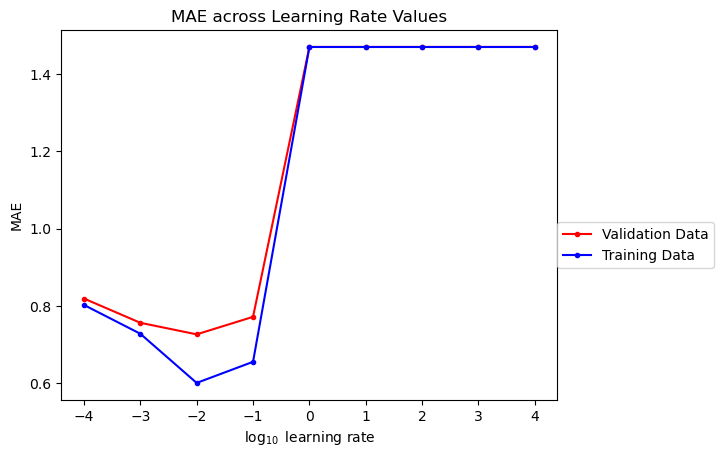

In [8]:
plt.plot(np.log10(lr_all), MAE_valid, '.-', color='red', label='Validation Data')
plt.plot(np.log10(lr_all), MAE_train, '.-', color='blue', label='Training Data')
plt.ylabel("MAE")
plt.legend(bbox_to_anchor=(1.33, 0.5))
plt.xlabel("$\log_{10}$ learning rate")
plt.title("MAE across Learning Rate Values")

In [9]:
K_vals = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
MAE_valid = []
MAE_train = []
for K in K_vals:
    k_test_model = SVDpp(n_factors=K, n_epochs=60, lr_all=0.01, reg_all=0.1, random_state=123453)    
    k_test_model.fit(training_split)
    results_valid = k_test_model.test(validation_split)
    results_train = k_test_model.test(training_split.build_testset())
    MAE_valid.append(accuracy.mae(results_valid))
    MAE_train.append(accuracy.mae(results_train))

MAE:  0.7299
MAE:  0.6746
MAE:  0.7294
MAE:  0.6415
MAE:  0.7266
MAE:  0.6008
MAE:  0.7257
MAE:  0.5790
MAE:  0.7267
MAE:  0.5616
MAE:  0.7285
MAE:  0.5476
MAE:  0.7261
MAE:  0.5395
MAE:  0.7269
MAE:  0.5305
MAE:  0.7268
MAE:  0.5244
MAE:  0.7274
MAE:  0.5169
MAE:  0.7282
MAE:  0.5128
MAE:  0.7256
MAE:  0.5096


In [13]:
min(MAE_valid)
MAE_valid.index(min(MAE_valid))
K_vals[MAE_valid.index(min(MAE_valid))]

55

Text(0.5, 1.0, 'MAE across K Values')

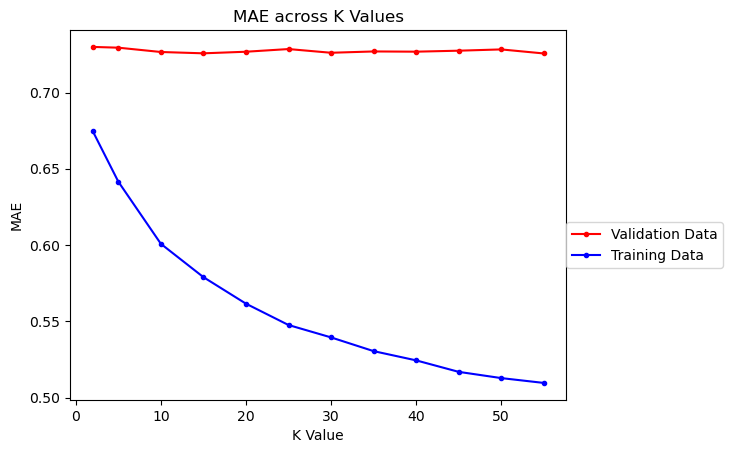

In [10]:
plt.plot(K_vals, MAE_valid, '.-', color='red', label='Validation Data')
plt.plot(K_vals, MAE_train, '.-', color='blue', label='Training Data')
plt.ylabel("MAE")
plt.legend(bbox_to_anchor=(1.33, 0.5))
plt.xlabel("K Value")
plt.title("MAE across K Values")

In [26]:
reg_all = np.logspace(-4, 4, 9)
MAE_valid = []
MAE_train = []
for reg in reg_all:
    k_test_model = SVDpp(n_factors=55, n_epochs=60, lr_all=0.01, reg_all=reg, random_state=123453)    
    k_test_model.fit(training_split)
    results_valid = k_test_model.test(validation_split)
    results_train = k_test_model.test(training_split.build_testset())
    MAE_valid.append(accuracy.mae(results_valid))
    MAE_train.append(accuracy.mae(results_train))

MAE:  0.8913
MAE:  0.1234
MAE:  0.8747
MAE:  0.1359
MAE:  0.8280
MAE:  0.1728
MAE:  0.7256
MAE:  0.5096
MAE:  0.8084
MAE:  0.7865
MAE:  0.9223
MAE:  0.9120
MAE:  0.9473
MAE:  0.9400
MAE:  1.4707
MAE:  1.4705
MAE:  1.4707
MAE:  1.4705


Text(0.5, 1.0, 'MAE across Regularization Term')

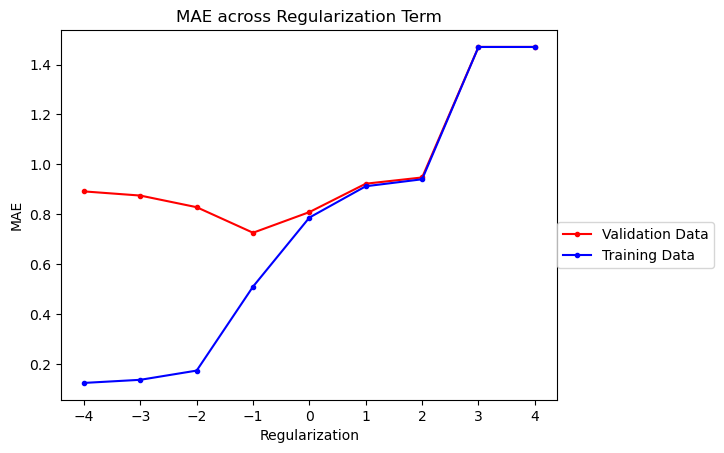

In [15]:
plt.plot(np.log10(reg_all), MAE_valid, '.-', color='red', label='Validation Data')
plt.plot(np.log10(reg_all), MAE_train, '.-', color='blue', label='Training Data')
plt.ylabel("MAE")
plt.legend(bbox_to_anchor=(1.33, 0.5))
plt.xlabel("Regularization")
plt.title("MAE across Regularization Term")

In [ ]:
print(results_valid)

In [ ]:
plt.plot(true_rating, predicted_rating, '.-', color='red', label='Validation Data')
plt.plot(np.log10(reg_all), MAE_train, '.-', color='blue', label='Training Data')
plt.ylabel("Predicted")
plt.legend(bbox_to_anchor=(1.33, 0.5))
plt.xlabel("True")
plt.title("Predicted vs True")

In [16]:
df_test = pd.read_csv(DATA_PATH + 'ratings_masked_leaderboard_set.csv')
test_set = Dataset.load_from_df(df_test, reader=reader)
test = test_set.build_full_trainset().build_testset()
print(test)

[(503, 204, nan), (503, 771, nan), (503, 121, nan), (503, 24, nan), (503, 116, nan), (503, 412, nan), (503, 138, nan), (503, 400, nan), (503, 544, nan), (503, 1134, nan), (503, 140, nan), (503, 1044, nan), (503, 199, nan), (503, 497, nan), (503, 844, nan), (503, 665, nan), (503, 8, nan), (503, 384, nan), (503, 415, nan), (503, 721, nan), (503, 368, nan), (503, 1442, nan), (503, 182, nan), (503, 150, nan), (503, 421, nan), (503, 932, nan), (503, 610, nan), (503, 184, nan), (503, 4, nan), (503, 64, nan), (503, 1039, nan), (503, 68, nan), (795, 185, nan), (795, 212, nan), (795, 217, nan), (795, 1030, nan), (795, 515, nan), (795, 99, nan), (795, 926, nan), (795, 427, nan), (795, 878, nan), (795, 793, nan), (795, 1010, nan), (795, 268, nan), (795, 538, nan), (795, 626, nan), (795, 663, nan), (795, 432, nan), (795, 154, nan), (795, 448, nan), (795, 81, nan), (795, 232, nan), (795, 53, nan), (795, 63, nan), (795, 589, nan), (795, 230, nan), (795, 746, nan), (795, 76, nan), (795, 86, nan), (79

In [25]:
svd = SVDpp(n_factors=10, n_epochs=60, lr_all=0.01, reg_all=0.1, random_state=123453)
svd.fit(training)

In [27]:
print(svd.trainset.global_mean)

3.529480398257623


In [18]:
test_results = svd.test(test)
estimated_scores = [result.est for result in test_results]

In [20]:
def write_to_file(results, name="predicted_ratings_leaderboard.txt"):
        with open(name, 'w') as file:
            for item in results:
                file.writelines(str(item) + "\n")

In [21]:
write_to_file(estimated_scores)